### Load sector data

##### span= 2 × half-life / log(2)

##### r_average = (1 + r_cumulative)**1/n -1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.width', 1000)  

# File IDs from the link
link_input = '1A9aTYrAWyEmIBHAw56XkM-H8ArF_kmuX'
download_url = f"https://drive.google.com/uc?id={link_input}"
input = pd.read_csv(download_url)

choose_from = ['Basic Materials', 'Energy', 'Financials', 'Industrials', 'Information Technology', 'Consumer Staples', 'Utilities', 'Healthcare', 'Consumer Discretionary']

sector = 'Basic Materials'

# Correlation matrix
#correlation_matrix = input.corr()
#print(correlation_matrix)

In [2]:
# Convert the 'DateTime' column to datetime and set it as the index
input['DateTime'] = pd.to_datetime(input['DateTime'], format='%d.%m.%Y %H:%M')
input.set_index('DateTime', inplace=True)

# Calculate daily returns for U.S. Basic Materials
input['Sector Returns'] = input[f'U.S. {sector}'].pct_change()

# Calculate log returns
input['Sector Log Returns'] = np.log(input[f'U.S. {sector}'] / input[f'U.S. {sector}'].shift(1))

# Define the target column
returns_column = 'Sector Log Returns'

# Exponentially Weighted Moving Downside Deviation (DD)
# Set the threshold for downside risk (mean return)
threshold = input['Sector Returns'].mean()

# Calculate downside deviation
dd_29 = input[returns_column].where(input[returns_column] < threshold).ewm(span=29, min_periods=1).std()
dd_14 = input[returns_column].where(input[returns_column] < threshold).ewm(span=14, min_periods=1).std()
dd_61 = input[returns_column].where(input[returns_column] < threshold).ewm(span=61, min_periods=1).std()

# Calculate average returns using EWM
average_returns_29 = input['Sector Returns'].ewm(span=29, min_periods=1).mean()
average_returns_14 = input['Sector Returns'].ewm(span=14, min_periods=1).mean()
average_returns_61 = input['Sector Returns'].ewm(span=61, min_periods=1).mean()

# Calculate the Sortino Ratio
sortino_ratio_29 = average_returns_29 / dd_29
sortino_ratio_14 = average_returns_14 / dd_14
sortino_ratio_61 = average_returns_61 / dd_61


# Combine results into a new DataFrame
all_data = pd.DataFrame({
    'EWM Downside Deviation (DD_29)': dd_29,
    'Average Returns (EWM_29)': average_returns_29,
    'Sortino Ratio 29': sortino_ratio_29,
    'EWM Downside Deviation (DD_14)': dd_14,
    'Average Returns (EWM_14)': average_returns_14,
    'Sortino Ratio 14': sortino_ratio_14,
    'Average Returns (EWM_61)': average_returns_61,
    'Sortino Ratio 61': sortino_ratio_61,
})

# Only expose the model to data until but not including 2019
cluster_sample = all_data[all_data.index < '2019-01-01']

# Display the result
print(cluster_sample)

            EWM Downside Deviation (DD_29)  Average Returns (EWM_29)  Sortino Ratio 29  EWM Downside Deviation (DD_14)  Average Returns (EWM_14)  Sortino Ratio 14  Average Returns (EWM_61)  Sortino Ratio 61
DateTime                                                                                                                                                                                                      
1998-12-22                             NaN                       NaN               NaN                             NaN                       NaN               NaN                       NaN               NaN
1998-12-23                             NaN                  0.010503               NaN                             NaN                  0.010503               NaN                  0.010503               NaN
1998-12-24                             NaN                  0.016974               NaN                             NaN                  0.017205               NaN          

### Clustering

In [3]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score

cluster_sample = cluster_sample.dropna()

# Extracting relevant columns as time series data
# Here, we treat each row as a different time series
data = cluster_sample[['EWM Downside Deviation (DD_29)', 'EWM Downside Deviation (DD_14)', 
               'Average Returns (EWM_29)', 'Average Returns (EWM_14)', 'Average Returns (EWM_61)',
               'Sortino Ratio 29', 'Sortino Ratio 14', 'Sortino Ratio 61']].values

# Reshape data for clustering
# Each time series is a row; we need to ensure proper shape
n_series = data.shape[0]
n_timestamps = data.shape[1]
X = data.reshape(n_series, n_timestamps)

# Scale the data
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X)

# Apply K-Means clustering using DTW
n_clusters = 2  # Adjust the number of clusters as needed
clusterer = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=42)
y_pred = clusterer.fit_predict(X_scaled)

# Calculate silhouette score
silhouette_avg = silhouette_score(X_scaled.reshape(n_series, -1), y_pred)
print("Silhouette Score:", silhouette_avg)

# Add cluster labels to the original DataFrame
cluster_sample['Cluster'] = y_pred

# Plotting the clusters
#plt.figure(figsize=(12, 8))
#for yi in range(n_clusters):
#    plt.subplot(n_clusters, 1, yi + 1)
#    for xx in X_scaled[y_pred == yi]:
#        plt.plot(xx.ravel(), "k-", alpha=0.5)  # plot individual series
#    plt.plot(clusterer.cluster_centers_[yi].ravel(), "r-", linewidth=2)  # plot the centroid
#    plt.title(f'Cluster {yi + 1}')
#plt.tight_layout()
#plt.show()

# Display the updated DataFrame
#print(cluster_sample[['EWM Downside Deviation (DD)', 'Average Returns (EWM)', 'Sortino Ratio', 'Cluster']])

/Users/georgiosgkolemis/Library/Python/3.9/lib/python/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Silhouette Score: 0.6520298960840769


### Average values for each cluster

As shown in the paper, two clusters come up, a bearish and a bullish one. 

Cluster 0 is bearish: higher downside deviation, lower returns and lower Sortino ratio. 

Cluster 1 is bullish: lower downside deviation, higher returns and higher Sortino ratio.

In [4]:
mean_cluster_0 = cluster_sample[cluster_sample['Cluster'] == 0].mean()
mean_cluster_1 = cluster_sample[cluster_sample['Cluster'] == 1].mean()

print("Mean for Cluster 0:")
print(mean_cluster_0)

print("\nMean for Cluster 1:")
print(mean_cluster_1)

Mean for Cluster 0:
EWM Downside Deviation (DD_29)    0.009786
Average Returns (EWM_29)         -0.001907
Sortino Ratio 29                 -0.180426
EWM Downside Deviation (DD_14)    0.009834
Average Returns (EWM_14)         -0.003024
Sortino Ratio 14                 -0.310481
Average Returns (EWM_61)         -0.000999
Sortino Ratio 61                 -0.082284
Cluster                           0.000000
dtype: float64

Mean for Cluster 1:
EWM Downside Deviation (DD_29)    0.007812
Average Returns (EWM_29)          0.001779
Sortino Ratio 29                  0.256161
EWM Downside Deviation (DD_14)    0.007219
Average Returns (EWM_14)          0.002511
Sortino Ratio 14                  0.386182
Average Returns (EWM_61)          0.001194
Sortino Ratio 61                  0.167190
Cluster                           1.000000
dtype: float64


### Load macro factors

Having separated the data in two clusters, we load the macroeconomic data (so far break-even inflation, yield curve, S&P 500 growth). The goal is to use them to train a classifier that will recognize and predict bullish and bearish regimes.

In [5]:
# File IDs from the link

# https://drive.google.com/file/d/1sc5xAObOnvvX4hxdh2bCnpGRuj3xVGDm/view?usp=share_link
link_yield_curve = '1sc5xAObOnvvX4hxdh2bCnpGRuj3xVGDm'
download_url_yc = f"https://drive.google.com/uc?id={link_yield_curve}"
yield_curve = pd.read_csv(download_url_yc)

# https://drive.google.com/file/d/1S0e5FLR3CwImP2tlCuybZEPnB-OjziM1/view?usp=share_link
link_volatility = '1S0e5FLR3CwImP2tlCuybZEPnB-OjziM1'
download_url_vol = f"https://drive.google.com/uc?id={link_volatility}"
volatility = pd.read_csv(download_url_vol)

# https://drive.google.com/file/d/1gcmdUr7tGZH433y-Q7obh4ROTIWpNP8P/view?usp=share_link
#link_spread_1_2 = '1gcmdUr7tGZH433y-Q7obh4ROTIWpNP8P'
#download_url_spread_1_2 = f"https://drive.google.com/uc?id={link_spread_1_2}"
#spread_1_2 = pd.read_csv(download_url_spread_1_2)

# https://drive.google.com/file/d/1JJRhDP_J8PnToeKNtXoDhqMioAb1k-6a/view?usp=share_link
link_corr_stocks_bonds = '1JJRhDP_J8PnToeKNtXoDhqMioAb1k-6a'
download_url_corr_stocks_bonds = f"https://drive.google.com/uc?id={link_corr_stocks_bonds}"
corr_stocks_bonds = pd.read_csv(download_url_corr_stocks_bonds)

cluster_sample=cluster_sample.reset_index()

### Feature engineering

In [6]:
# Convert 'DateTime' column to datetime type if not already done
yield_curve['DateTime'] = pd.to_datetime(yield_curve['DateTime'])
volatility['DateTime'] = pd.to_datetime(volatility['DateTime'], format='%d.%m.%Y %H:%M', errors='coerce')
#spread_1_2['DateTime'] = pd.to_datetime(spread_1_2['DateTime'])
corr_stocks_bonds['DateTime'] = pd.to_datetime(corr_stocks_bonds['DateTime'])
cluster_sample['DateTime'] = pd.to_datetime(cluster_sample['DateTime'])

# Calculate the 21-day EWMA for the growth of the macroeconomic factors
yield_curve['Growth'] = yield_curve['Spread between 10-year Yield and 3-month Yield'].pct_change(fill_method=None)
yield_curve['EWMA_yield_curve_29'] = yield_curve['Growth'].ewm(span=29, adjust=False).mean()
yield_curve['EWMA_yield_curve_61_diff'] = yield_curve['Growth'].diff()
yield_curve['EWMA_yield_curve_61'] = yield_curve['EWMA_yield_curve_61_diff'].ewm(span=61, adjust=False).mean()
yield_curve = yield_curve[['DateTime', 'EWMA_yield_curve_29','EWMA_yield_curve_61']]

volatility['Volatility Change'] = np.log(volatility['S&P 500 VIX'].diff())
volatility['EWMA_volatility'] = volatility['Volatility Change'].ewm(span=183, adjust=False).mean()
volatility = volatility[['DateTime','EWMA_volatility']]

#spread_1_2['Spread12 Change'] = spread_1_2['Spread between 2-year Yield and 1-year Yield'].pct_change(fill_method=None)
#spread_1_2['EWMA_spread12']= spread_1_2['Spread12 Change'].ewm(span=61, adjust=False).mean()
#spread_1_2 = spread_1_2[['DateTime','EWMA_spread12']]

# Merge the inflation and sector-specific DataFrames on 'DateTime', keeping only common rows
all_inputs_df = pd.merge(yield_curve, cluster_sample, on='DateTime', how='inner')
all_inputs_df = pd.merge(all_inputs_df, volatility, on='DateTime', how='inner')
#all_inputs_df = pd.merge(all_inputs_df, spread_1_2, on='DateTime', how='inner')
all_inputs_df = pd.merge(all_inputs_df, corr_stocks_bonds, on='DateTime', how='outer')

all_inputs_df['1-Year Rolling Correlation'] = all_inputs_df['1-Year Rolling Correlation'].ffill()

columns_to_keep = ['DateTime', 'EWMA_yield_curve_29','EWMA_yield_curve_61', 'EWMA_volatility' , '1-Year Rolling Correlation',
                   'Sortino Ratio 29','Sortino Ratio 14','Sortino Ratio 61',
                   'EWM Downside Deviation (DD_29)', 'EWM Downside Deviation (DD_14)', 
                   'Average Returns (EWM_29)', 'Average Returns (EWM_14)', 'Average Returns (EWM_61)', 
                   'Cluster']
final_input_df = all_inputs_df[columns_to_keep].copy()

final_input_df.dropna(inplace=True)

# Display the merged DataFrame
print(final_input_df)

        DateTime  EWMA_yield_curve_29  EWMA_yield_curve_61  EWMA_volatility  1-Year Rolling Correlation  Sortino Ratio 29  Sortino Ratio 14  Sortino Ratio 61  EWM Downside Deviation (DD_29)  EWM Downside Deviation (DD_14)  Average Returns (EWM_29)  Average Returns (EWM_14)  Average Returns (EWM_61)  Cluster
6625  1998-12-30             0.004490            -0.003666        -0.427235                   -0.522280          1.834320          1.720195          1.889834                        0.004148                        0.004148                  0.007609                  0.007136                  0.007840      1.0
6626  1998-12-31             0.025972             0.009766        -0.421755                   -0.522280          2.020467          1.965599          2.050761                        0.004148                        0.004148                  0.008382                  0.008154                  0.008507      1.0
6628  1999-01-04             0.031455             0.002401        -0.4217

/Users/georgiosgkolemis/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/georgiosgkolemis/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Class imbalance

There are more samples of Cluster 1 than Cluster 0. We take this into account in the following training of the classifier.

In [7]:
final_input_df['Cluster'].value_counts()

Cluster
1.0    2996
0.0    2006
Name: count, dtype: int64

### Classifier

##### We shift the data so each row of inputs corresponds to the cluster of the next day, because we want our classifier to be able to predict what cluster the next day/month will be so that we adjust the asset allocation accordingly. We split the data 80/20 into train and test sample and use HistGradientBoostingClassifier which is similar to what they used in the paper. The scores the clssifier achieves seem satisfactory.

##### The HistGradientBoostingClassifier is an efficient, histogram-based implementation of gradient boosting for classification tasks. It builds an ensemble of weak learners (typically decision trees) sequentially, where each new tree corrects the errors of the previous ones. By using histograms to bin feature values, it significantly speeds up training and reduces memory usage, making it suitable for large datasets and high-dimensional feature spaces. This classifier is particularly effective in handling missing values and is robust against overfitting.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import HistGradientBoostingClassifier
import joblib

# Copy final_df for processing
data = final_input_df.copy()

# Shift the 'Cluster' column down by one row to align it with tomorrow's data for predictability
data['Cluster_Tomorrow'] = data['Cluster'].shift(-1)

# Prepare features, target variable, and the DateTime column
X = data[['EWMA_yield_curve_29','EWMA_yield_curve_61', 'EWMA_volatility', '1-Year Rolling Correlation', 'Sortino Ratio 14', 'Sortino Ratio 29', 'Sortino Ratio 61',
          'EWM Downside Deviation (DD_29)', 'EWM Downside Deviation (DD_14)', 
               'Average Returns (EWM_29)', 'Average Returns (EWM_14)', 'Average Returns (EWM_61)']]  # Features
y = data['Cluster_Tomorrow']  # Target variable
dates = data['DateTime']  # Keep DateTime for later use

# Drop rows with NaN values caused by the shift
X = X[:-1]  # Remove the last row for features
y = y[:-1]  # Remove the last row for target
dates = dates[:-1]  # Remove last date to match X and y

# Split data into training and testing sets, preserving order
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.1, shuffle=False)

# Create and train the classifier with balanced class weights
classifier = HistGradientBoostingClassifier(class_weight='balanced', l2_regularization= 10)
classifier.fit(X_train, y_train)

# Save model
joblib.dump(classifier, f'models/{sector}_classifier.pkl')

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.83
              precision    recall  f1-score   support

         0.0       0.79      0.74      0.76       186
         1.0       0.85      0.89      0.87       315

    accuracy                           0.83       501
   macro avg       0.82      0.81      0.82       501
weighted avg       0.83      0.83      0.83       501



In [9]:
# Keep the rest for out of sample test
test_sample = all_data[all_data.index >= '2019-01-01']
test_sample = test_sample.reset_index()
test_sample['DateTime'] = pd.to_datetime(test_sample['DateTime'])

# Merge the inflation and sector-specific DataFrames on 'DateTime', keeping only common rows
test_df = pd.merge(yield_curve[yield_curve['DateTime'] >= '2019-01-01'], test_sample, on='DateTime', how='inner')
test_df = pd.merge(test_df, volatility[volatility['DateTime'] >= '2019-01-01'], on='DateTime', how='inner')
#test_df = pd.merge(test_df, spread_1_2, on='DateTime', how='inner')
test_df = pd.merge(test_df, corr_stocks_bonds[corr_stocks_bonds['DateTime'] >= '2019-01-01'], on='DateTime', how='outer')

test_df['1-Year Rolling Correlation'] = test_df['1-Year Rolling Correlation'].ffill()

columns_to_keep = ['DateTime', 'EWMA_yield_curve_29','EWMA_yield_curve_61', 'EWMA_volatility' , '1-Year Rolling Correlation',
                   'Sortino Ratio 29','Sortino Ratio 14','Sortino Ratio 61',
                   'EWM Downside Deviation (DD_29)', 'EWM Downside Deviation (DD_14)', 
                   'Average Returns (EWM_29)', 'Average Returns (EWM_14)', 'Average Returns (EWM_61)' ]

final_test_df = test_df[columns_to_keep].copy()

final_test_df.dropna(inplace=True)

# Display the merged DataFrame
print(final_test_df)

       DateTime  EWMA_yield_curve_29  EWMA_yield_curve_61  EWMA_volatility  1-Year Rolling Correlation  Sortino Ratio 29  Sortino Ratio 14  Sortino Ratio 61  EWM Downside Deviation (DD_29)  EWM Downside Deviation (DD_14)  Average Returns (EWM_29)  Average Returns (EWM_14)  Average Returns (EWM_61)
4    2019-01-07            -0.013373            -0.001003        -0.655506                    0.501508          0.039619          0.295016         -0.083997                        0.008940                        0.009732                  0.000354                  0.002871                 -0.000735
5    2019-01-08            -0.005074             0.004007        -0.655506                    0.501508          0.115230          0.399451         -0.042606                        0.008940                        0.009732                  0.001030                  0.003887                 -0.000373
6    2019-01-09            -0.006403            -0.000513        -0.655506                    0.501508 

##### Make predictions on out of sample. Calculate actual sector returns and predicted returns based on 0/1 startegy.

In [10]:
# Predict clusters for test data (post-2019)
prediction_set = final_test_df[['EWMA_yield_curve_29','EWMA_yield_curve_61', 'EWMA_volatility', '1-Year Rolling Correlation', 
                                'Sortino Ratio 14', 'Sortino Ratio 29', 'Sortino Ratio 61',
                                'EWM Downside Deviation (DD_29)', 'EWM Downside Deviation (DD_14)', 
                                'Average Returns (EWM_29)', 'Average Returns (EWM_14)', 'Average Returns (EWM_61)']]

cluster_predictions = classifier.predict(prediction_set)
final_test_df['Predicted_Cluster'] = cluster_predictions 

# Dropping columns in-place
final_test_df.drop(['Sortino Ratio 14', 'Sortino Ratio 29', 'Sortino Ratio 61', 'EWMA_yield_curve_29','EWMA_yield_curve_61', 'EWMA_volatility','1-Year Rolling Correlation', 
                   'EWM Downside Deviation (DD_29)', 'EWM Downside Deviation (DD_14)', 
               'Average Returns (EWM_29)', 'Average Returns (EWM_14)', 'Average Returns (EWM_61)',], axis=1, inplace=True)

# Ensure 'DateTime' is set as the index for alignment purposes
returns_series = input['Sector Returns'].dropna()
returns_series.index = pd.to_datetime(returns_series.index)  # Ensure DateTime index for returns
final_dates = final_test_df['DateTime'].copy()  # Copy dates from final_df for alignment

# Filter and align 'returns_series' with 'final_dates'
aligned_returns = returns_series[returns_series.index.isin(final_dates)].reindex(final_dates).dropna()

# Calculate cumulative returns
cumulative_returns = (1 + aligned_returns).cumprod() - 1

# First find average annual return equal to r_average = (1 + r_cumulative)**1/n -1. Then substract the risk free rate (1.1%) and divide by the annualised standard deviation
sharpe_ratio_actual = ((1 +cumulative_returns.iloc[-1]) ** (1/5.8) -1 - 0.011) / (aligned_returns.std() * np.sqrt(252))

print(f'Actual Return (total return): {cumulative_returns.iloc[-1]:.2f}')
print(f'Actual Risk Adjusted Return (return per risk unit): {sharpe_ratio_actual:.2f}')

Actual Return (total return): 0.86
Actual Risk Adjusted Return (return per risk unit): 0.44


In [11]:
# Integrate actual returns in our test_results dataframe
helper_returns_df = aligned_returns.copy()
helper_returns_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)
final_test_df['Actual_Daily_Returns'] = helper_returns_df

final_test_df.to_csv( f'predictions/{sector}_predictions.csv', index=False)

In [12]:
# Initialize the portfolio value column
initial_investment = 100000  # Starting with $100,000
final_test_df['Portfolio_Value'] = float(initial_investment)
in_market = False  # Start by being out of the market

# Loop through the predictions to simulate portfolio
for i in range(len(final_test_df)-1):
    if final_test_df['Predicted_Cluster'].iloc[i] == 1:  # Predicted bullish
        if not in_market:  # Enter the market if we were out
            in_market = True
        # Adjust portfolio value by the market return
        final_test_df.loc[i+1, 'Portfolio_Value'] = float(final_test_df.loc[i, 'Portfolio_Value'] * (1 + final_test_df['Actual_Daily_Returns'].iloc[i+1]))
    elif final_test_df['Predicted_Cluster'].iloc[i] == 0:  # Predicted bearish
        in_market = False  # Exit the market
        # Keep portfolio value unchanged if out of market
        final_test_df.loc[i+1, 'Portfolio_Value'] = float(final_test_df.loc[i, 'Portfolio_Value']) * (1 + 0.011/365)

# Calculate total return from the initial investment
total_return = (final_test_df['Portfolio_Value'].iloc[-1] - initial_investment) / initial_investment
print(f'Total Portfolio Return: {total_return:.2f}')

# Calculate standard deviation of portfolio returns
final_test_df['Portfolio_Returns'] = final_test_df['Portfolio_Value'].pct_change()
portfolio_std = final_test_df['Portfolio_Returns'].std()

# Calculate daily returns
final_test_df['Daily_Return'] = final_test_df['Portfolio_Value'].pct_change()

# Calculate cumulative returns
final_test_df['Cumulative_Return'] = (1 + final_test_df['Daily_Return']).cumprod() - 1

# First find average annual return equal to r_average = (1 + r_cumulative)**1/n -1. Then substract the risk free rate (1.1%) and divide by the annualised standrd deviation
sharpe_ratio_predicted = ((1 +final_test_df['Cumulative_Return'].iloc[-1]) ** (1/5.8) - 1 - 0.011) / (final_test_df['Portfolio_Returns'].std() * np.sqrt(252))

print(f'Risk Adjusted Portfolio Return: {sharpe_ratio_predicted:.2f}')

Total Portfolio Return: 0.72
Risk Adjusted Portfolio Return: 0.60


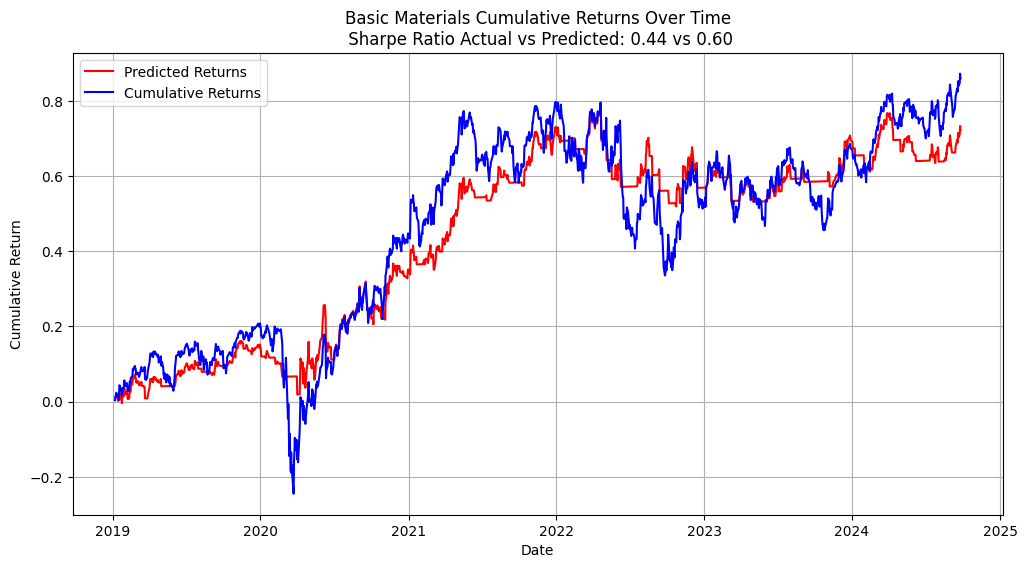

In [13]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(final_test_df['DateTime'],final_test_df['Cumulative_Return'], color="red", label="Predicted Returns")
plt.plot(final_test_df['DateTime'],cumulative_returns, color="blue", label="Cumulative Returns")
plt.title(f"{sector} Cumulative Returns Over Time\n Sharpe Ratio Actual vs Predicted: {sharpe_ratio_actual:.2f} vs {sharpe_ratio_predicted:.2f}")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.savefig(f'plots/{sector}.png')
plt.show()

/Users/georgiosgkolemis/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


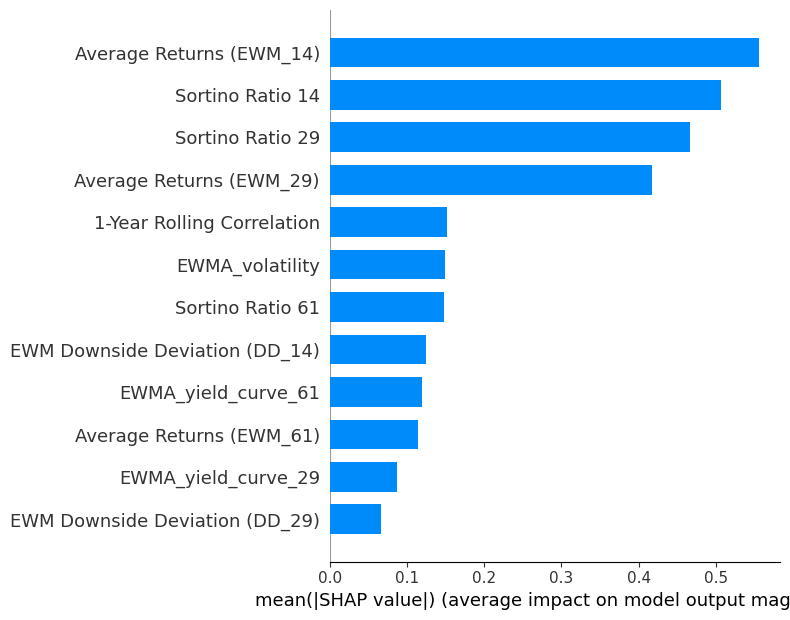

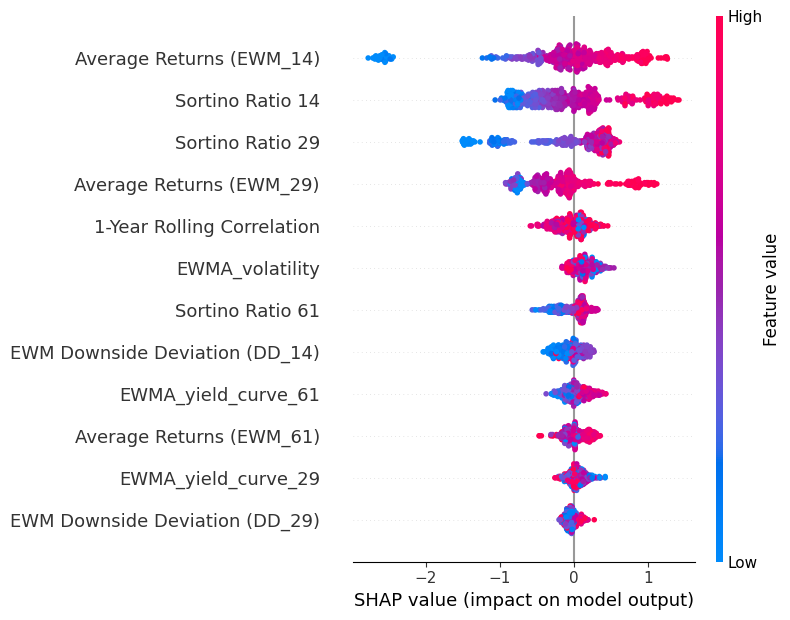

In [14]:
import shap

# Initialize the TreeExplainer for your trained classifier
explainer = shap.Explainer(classifier, X_train)

# Compute SHAP values for the test set
shap_values = explainer(X_test, check_additivity=False)

# Plot summary to show global feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)